## *Statistics coded:* Government Finance Statistics

Prepared by [**Bonamino Luca**](luca.bonamino@hotmail.com)

This notebook aims at illustrating the *Statistics Explained* article on [government finance statistics](https://ec.europa.eu/eurostat/statistics-explained/index.php/Government_finance_statistics).


## Settings required

### Built-il libraries

In [1]:
import requests
import json
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Costum libraries

In [2]:
import sys
costum_lib_locations = ['../../src/python']
for location in costum_lib_locations:
    if location not in sys.path:
        sys.path.append(location)
import requestLib
import dataDealer

### Variables needed in the notebook

Default variables that are used throughout the notebook
* **noCountry**: countries that are not shown in the plots -> type: list
* **clean_country**: countries that are renamed in the plots in a contracted form -> type: dict
* **host_url**: base url for the data extraction -> type: string

In [3]:
noCountry = ['European Union - 27 countries (2007-2013)' ,
             'European Union - 25 countries (2004-2006)',
             'European Union - 15 countries (1995-2004)',
             'Euro area - 11 countries (1999-2000)',
             'Euro area - 12 countries (2001-2006)',
             'Euro area - 13 countries (2007)',
             'Euro area - 15 countries (2008)',
             'Euro area - 16 countries (2009-2010)',
             'Euro area - 18 countries (2014)',
             'Euro area - 17 countries (2011-2013)',
             'Switzerland'
            ]

clean_country = {'Germany': 'Germany',
                 'Euro area - 19' : 'Euro Area (EA-19)', 
                 'European Union - 27 countries (from ': 'EU-27', 
                 'European Union - 28' : 'EU-28'}

host_url = "http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/"

### Functions needed in the notebook

* **assign_reference**: set lines and columns to prepare the dataFrame creation
* **response_fun**: main function that extracts the data from the server and returns the response object whose attributes are the data in dictionary, string and dataframe datatype
* **prepare_for_plot**: return plottable values from the data used in the last two sections

In [4]:
def assign_reference(data, multiplicity='time'):
    '''
    set lines and columns to prepare the dataFrame creation
        
        params: data: dict: dictionary of data
        params: multiciplity: string: multiple key argument
        
        return: {'lines' : lines, 'columns': columns} : dict: dataFramestructure
    '''
    lines = list(list(data['dimension']['geo']['category'].values())[1].values())
    columns= list(list(data['dimension'][multiplicity]['category'].values())[1].values())
    return {'lines' : lines, 'columns': columns}

def prepare_for_plot(instances, total, subtraction=False, where=(False,False)):
    '''
    Prepare data for the bar plot
        
        params: instances: list: list of instances of the component to request 
                                    - look at the last sections form more explainations
        params: total: dict: total compoment 
        params: substraction: bollean: set if there is a substraction in the percentage calculations 
                                            - False by default, can only diffear from the default value if 
                                                "where" is not (False, False)
        params: where: tuple: say for which compoments there is the subtraction 
                                            - (False, False) by default, can only diffear from the default value if 
                                                "subtraction" is set to True
        
        return: output: dict: data ready for the bar component plot
    '''
    if where != (False, False) and not subtraction:
        print('[-] Bad arguments !\n Cannot give the wehe argument of no subtraction is present')
        return False
    elif subtraction and where == (False,False):
        print('[-] Bad arguments !\n Need to tell where the substraction is')
        
    output = {}
    for item in instances:
        countries = item.response.lines
        values = item.response.values
        name = item.name
        if len(values.keys()) > 1:
            tmp = {}
            for item in countries:
                tmp[item] = []
            for key in values:
                for c in values[key]:
                    tmp[c].append(values[key][c])
            temp = {}
            for key in tmp:
                
                if subtraction:
                    if where[0] in list(values.keys()):
                        s = 0
                        for i in range(len(tmp[key])):
                            if i == where[1]:
                                s += -tmp[key][i]
                            else:
                                s += tmp[key][i]
                        if total[key] != 0:
                            temp[key] = s / total[key] * 100
                        else:
                            temp[key] = 0.
                    else:    
                        if total[key] != 0:
                            temp[key] = sum(tmp[key]) / total[key] * 100
                        else:
                            temp[key] = 0.
                    output[name] = temp
                else:    
                    if total[key] != 0:
                        temp[key] = sum(tmp[key]) / total[key] * 100
                    else:
                        temp[key] = 0.
            output[name] = temp
        else:
            temp = {}
            label = list(values.keys())[0]
            for key in values[label]:
                if total[key] != 0:
                    temp[key] = values[label][key] / total[key] * 100
                else:
                    temp[key] = 0.
            output[name] = temp
    return output

def response_fun(client, args={}, remove_list=[], clean_dict={}, void_item=False, multiplicity='time', display_success=False, toZero=True):
    '''
    Extracts the data from the server and returns the response object whose attributes are the data in dictionary, 
        string and dataframe datatype
        
        param: client: requestLib.RequestHandeler_Object: object that performs the GET request tothe eurostat 
                                                                server
        param: args: dict: arguments for the url to request - empty by default
        param: remove_list: list: countries that are not shown in the plots - empty by default
        param: clean_dict: dict: countries that are renamed in the plots in a contracted form - empty by default
        param: void_item: boolean: void labels for not shown countries - False by default
        param: multiciplity: string: multiple key argument - "time" by default
        param: display_success: boolean: print success status - False by default
        
        return: response: requestLib.Response_Object
    '''
    if args != {}:
        response = client.get_request(args, display_success=display_success)
    else:
        response = client.get_request(client.args)
    frame = assign_reference(response.data['dict'], multiplicity=multiplicity)
    country = frame['lines']
    times = frame['columns']
    if 'status' not in list(response.data['dict'].keys()):
        v = list(response.data['dict']['value'].values())
    else:
        if toZero:
            v = dataDealer.check_data_by_status(response.data['dict'], toZero=True)
        else:
            v = dataDealer.check_data_by_status(response.data['dict'], toZero=False)
    response.values, response.lines = dataDealer.json_to_data(lines=frame['lines'], 
                                         columns=frame['columns'], 
                                         values=v, 
                                         remove_list=remove_list, 
                                         void_item=void_item, 
                                         clean_dict=clean_dict,
                                         multiple_key=multiplicity)
    
    response.DF = dataDealer.subjason_to_DataFrame(lines=response.lines, columns=times, subDict=response.values)
    response.x_labels = dataDealer.clean_label(lines=response.lines, remove_list=remove_list)
    
    return response
    


### Instancences

Two main instances are presentin this notebook
* **client**: object that performs the GET request tothe eurostat server -> only instancied once
* **response**: response object returned by the return_fun, containig the whole data -> inctancied at each GET request by the client

In [5]:
client = requestLib.RequestHandeler(host_url)

## Procedure

For each visualisation we perform the following steps:

<ol>
<li>Prepare the GET request url arguments</li>
<li>
    <ol>
        <li>If not prepared before or if the request is not directly related to the one just before, the **args_to_dict** method of the **requestLib** module is used</li>
        <li>If only few arguments need to be chaged from the privious request, the **update_args** method of the client instance is used</li>
       </ol>
 </li>
<li>Run the **response_fun** function with the proper arguments (look at the description in the function definition)</li>
<li>If more calculations are needed, do them. If not, jump to the next point</li>
<li>Plot the data or print the subdataframe depending on what has to be shown</li>
</ol>    

The last two sections: **Main components of government revenu** and **Main components of government expenditures** need a different precedure, see the explainations under the **Main components of government revenu, 2019** section

# Public Balance 2018 and 2019

Arguments for the GET request:

* **sector** = S13 - general government
* **na_item** = B9 - Net borrowing or lending
* **time** = 2018,2019 - 2018 & 2019
* **unit** = PC_GDP - percentage of GDP

Arguments to **response_fun** and plot filters:
* **clean_dict**: clean_country
* **remove_list**: noCountry
* **void_item**: True - void labels for non shown countries

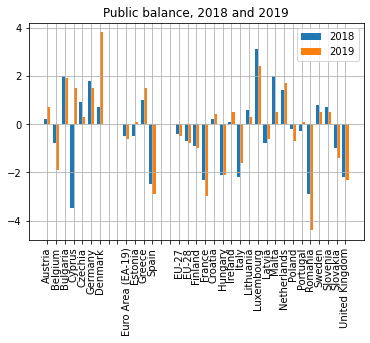

In [6]:
#%matplotlib inline
#args = requestLib.args_to_dict('table= gov_10dd_edpt1', 'na_item=B9', 'precision=1', 'unit=PC_GDP', 'time=2018,2019','sector=S13')
args = requestLib.args_to_dict_fun(table='gov_10dd_edpt1', na_item='B9', unit = 'PC_GDP', time='2018,2019', sector='S13')
r = response_fun(client,  clean_dict=clean_country, remove_list=noCountry,args=args, void_item=True)

fig, ax = plt.subplots()
plt.title("Public balance, 2018 and 2019")
pos = np.arange(len(r.x_labels))
ax.set_xticks(pos)
ax.set_xticklabels(r.x_labels, rotation = 90)
width = 0.35

ax.bar(pos -  width/2., list(r.values['2018'].values()),  width, label='2018')
ax.bar(pos +  width/2., list(r.values['2019'].values()),  width, label='2019')
plt.legend(loc='upper right')
plt.grid()
plt.show()


# Public Balance and General Governement Debt, 2016-2019

In [7]:
r = response_fun(client,  clean_dict=clean_country, remove_list=noCountry,args=args, void_item=True)
debt = r.DF
debt

,2018,2019
Austria,0.2,0.7
Belgium,-0.8,-1.9
Bulgaria,2.0,1.9
Cyprus,-3.5,1.5
Czechia,0.9,0.3
Germany,1.8,1.5
Denmark,0.7,3.8
Euro area - 17 countries (2011-2013),0.0,0.0
Euro area - 18 countries (2014),0.0,0.0
Euro Area (EA-19),-0.5,-0.6


## General government debt, 2019 and 2018

Arguments for the GET request:

* **sector** = S13 - general government
* **na_item** = GD - conslidated gross
* **time** = 2018,2019 - 2018 & 2019
* **unit** = PC_GDP - percentage of GDP

Arguments to **response_fun** and plot filters:
* **clean_dict**: clean_country
* **remove_list**: noCountry
* **void_item**: True - void labels for non shown countries

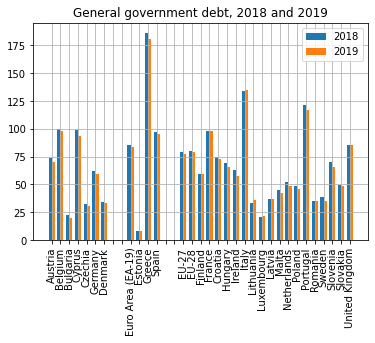

In [8]:
args = requestLib.args_to_dict_fun(table='gov_10dd_edpt1', na_item='GD', unit = 'PC_GDP', time='2018,2019', sector='S13')

r = response_fun(client,  clean_dict=clean_country, remove_list=noCountry, void_item=True, args=args)

pos = np.arange(len(r.x_labels))

fig, ax = plt.subplots()
plt.title("General government debt, 2018 and 2019")
ax.set_xticks(pos)
ax.set_xticklabels(r.x_labels, rotation = 90)
width = 0.35

ax.bar(pos -  width/2., list(r.values['2018'].values()),  width, label='2018')
ax.bar(pos +  width/2., list(r.values['2019'].values()),  width, label='2019')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Government revenu and expenditure 2009 - 2019 

### Development of total expenditure and total revenue 2009-2019 (% of GDP)

#### Arguments for the GET request:

First request
* **sector** = S13 - general government
* **na_item** = TE - total expenditure
* **time** = 2009,2010,2011,2012,2013,2014,2015,2016,2017,1018,2019 - from 2009 to 2019
* **unit** = PC_GDP - percentage of GDP

Second request
* **sector** = S13 - general government
* **na_item** = TR - total ereveue
* **time** = 2009,2010,2011,2012,2013,2014,2015,2016,2017,1018,2019 - from 2009 to 2019
* **unit** = PC_GDP - percentage of GDP

#### Arguments to **response_fun** and filter countries:
* **clean_dict**: clean_country (defined above)
* Only the countries **EU-27** and **Euro Area (EA-19)**

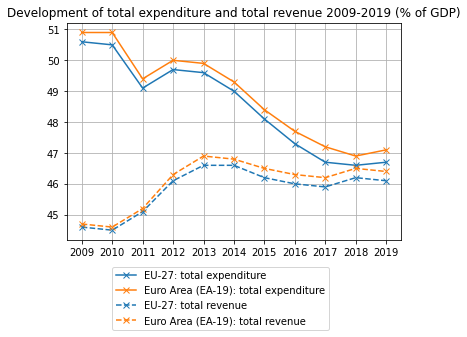

In [9]:
y = {'total expenditure': {'EU-27':[],'Euro Area (EA-19)' :[] }, 
     'total revenue': {'EU-27':[],'Euro Area (EA-19)' :[] }
     }
args = requestLib.args_to_dict_fun(table = 'gov_10a_main',
                                   na_item = 'TE',
                                   unit = 'PC_GDP',
                                   time = '2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019',
                                sector = 'S13')
expenditures = response_fun(client,  clean_dict=clean_country,args=args)
for country in y['total expenditure']:
    for year in expenditures.values:
        y['total expenditure'][country].append(expenditures.values[year][country])

args = client.update_args('na_item=TR')
revenues = response_fun(client,  clean_dict=clean_country, args = args)

for country in y['total revenue']:
    for year in revenues.values:
        y['total revenue'][country].append(revenues.values[year][country])

##### PLOT
plot_colors = ['C0', 'C1']
plt.title("Development of total expenditure and total revenue 2009-2019 (% of GDP)")
x = list(revenues.values.keys())
for measure in y:
    i = 0
    for country in y[measure]:
        if measure == 'total revenue':
            line_style = '--'
        else:
            line_style = '-'   
        plt.plot(x,y[measure][country],ls=line_style, marker='x', label='%s: %s' % (country, measure), color=plot_colors[i])
        i += 1
plt.grid()
plt.legend(bbox_to_anchor=(0.8, -0.1))
plt.show()

### Development of total expenditure and total revenue 2009-2019 (Billion EUR)

#### Arguments for the GET request:

First request
* **sector** = S13 - general government
* **na_item** = TE - total expenditure
* **time** = 2009,2010,2011,2012,2013,2014,2015,2016,2017,1018,2019 - from 2009 to 2019
* **unit** = MIO_EUR - billion EUR

Second request
* **sector** = S13 - general government
* **na_item** = TR - total ereveue
* **time** = 2009,2010,2011,2012,2013,2014,2015,2016,2017,1018,2019 - from 2009 to 2019
* **unit** = MIO_EUR - billion EUR

#### Arguments to **response_fun** and filter countries:
* **clean_dict**: clean_country (defined above)
* Only the countries **EU-27** and **Euro Area (EA-19)**

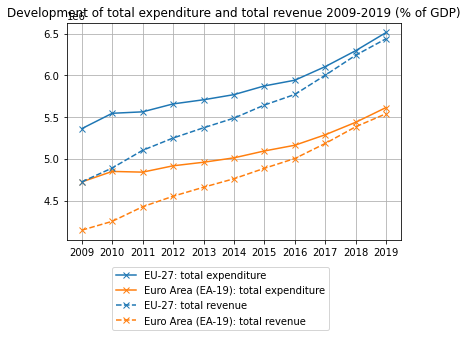

In [10]:
y = {'total expenditure': {'EU-27':[],'Euro Area (EA-19)' :[] }, 
     'total revenue': {'EU-27':[],'Euro Area (EA-19)' :[] }
     }

args = requestLib.args_to_dict('table=gov_10a_main', 
                    'na_item=TE', 
                    'precision=1', 
                    'unit=MIO_EUR', 
                    'time= 2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019',
                    'sector=S13')

expenditures = response_fun(client,  clean_dict=clean_country, args = args)

for country in y['total expenditure']:
    for year in expenditures.values:
        y['total expenditure'][country].append(expenditures.values[year][country])
        
args = client.update_args('na_item=TR')
revenues = response_fun(client,  clean_dict=clean_country, args = args)

for country in y['total revenue']:
    for year in revenues.values:
        y['total revenue'][country].append(revenues.values[year][country])

##### PLOT
plot_colors = ['C0', 'C1']
plt.title("Development of total expenditure and total revenue 2009-2019 (% of GDP)")
x = list(revenues.values.keys())
for measure in y:
    i = 0
    for country in y[measure]:
        if measure == 'total revenue':
            line_style = '--'
        else:
            line_style = '-'   
        plt.plot(x,y[measure][country],ls=line_style, marker='x', label='%s: %s' % (country, measure), color=plot_colors[i])
        i += 1
plt.grid()
plt.legend(bbox_to_anchor=(0.8, -0.1))
plt.show()

### Governement revenue and expenditure, 2019

Arguments for the GET request:
* **sector**: S13 - general goverment
* **na_item**: TE,TR - total expenditures & total revenues
* **time**: 2019

Arguments to **response_fun** and plot filters
* **remove_list**: noCountry (defined above)
* **clean_dict**: clean_countries (defined above)
* **void_item**: True - void labels for not shown countries
* **multiciplity**: na_item

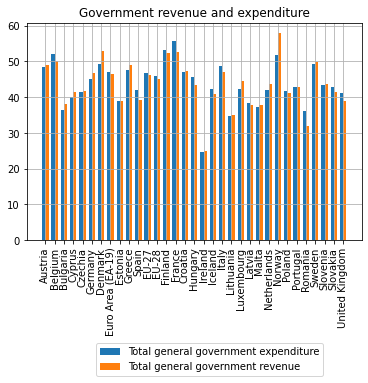

In [11]:
args = requestLib.args_to_dict('table=gov_10a_main', 
                    'na_item=TE,TR', 
                    'precision=1', 
                    'unit=PC_GDP', 
                    'time= 2019',
                    'sector=S13')

r = response_fun(client,  clean_dict=clean_country, remove_list=noCountry,void_item=False,multiplicity='na_item' ,args = args)

pos = np.arange(len(r.x_labels))
fig, ax = plt.subplots()

plt.title("Government revenue and expenditure")
ax.set_xticks(pos)
ax.set_xticklabels(r.x_labels, rotation = 90)
width = 0.35
a = pos - width/2.

ax.bar(pos - width/2., list(r.values['Total general government expenditure'].values()),  width, label='Total general government expenditure')
ax.bar(pos +  width/2., list(r.values['Total general government revenue'].values()),  width, label='Total general government revenue')
plt.legend(bbox_to_anchor=(0.9, -0.45))

plt.grid()
plt.show()

### Main components of government revenu, 2019

Values used:
![total revenu as a functions of the na_items of the components](revenu.png "Title")

Not all countries in the databse present all the components searched. Therefore only all the countries prenseting these componets are plotted. 

In a first step all the countries are extracted in all the requests, then after a filter, a second sequence of extraction is done with oly the relevent onces.

The filter is implemented by checiking the request with the smaller number of countries returned, from which we are able to find then countries that have to be neglected for the plot.

The implementation of the secrion is done using the **Component** class and the **return_response** function defined below

#### **Component** class
Each component of the total rvenu/expenditure is an instance of the **Component** class

Arguments to the construction function:
* **name**: name of the component
* **na_item**: the correponding na_item/s
* **label**: the label to show in the plot

In [12]:
class Component:
    def __init__(self,name, na_item, label):
        self.name = name
        self.na_item = na_item
        self.label = label

#### return_response function
Takes as inputs the list of instances, the default *remove_list* defined in the section above and the *client* object instanced above. It returns the lenghts of the returns countries and the **Compoment** instaces updated by the response of the GET request

In [13]:
def return_response(istances, remove_list, client):
    lens = []
    for instance in istances:
        client.update_args('na_item=%s' % (instance.na_item))
        instance.response = response_fun(client, clean_dict=clean_country, remove_list=remove_list, void_item=False, multiplicity='na_item')
        lens.append(len(instance.response.lines))
    return lens, instances

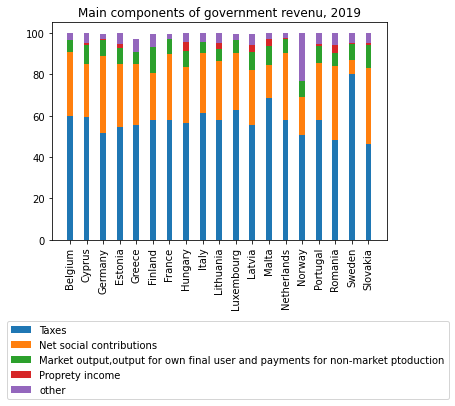

In [14]:
taxes = Component('taxes','D2REC,D5REC,D91REC', 'Taxes')
social_contribution = Component('social contributions','D61REC', 'Net social contributions')
sales = Component('sales', 'P11_P12_P131', 'Market output,output for own final user and payments for non-market ptoduction')
proprety_income = Component('proprety income','D92REC,D99REC', 'Proprety income')
other = Component('other','D39REC,D4REC,D7REC', 'other')

instances = [taxes, social_contribution,sales, proprety_income, other]
args = requestLib.args_to_dict_fun(table='gov_10a_main', unit = 'PC_GDP', time='2019', sector='S13', na_item='')

lens, instances = return_response(instances, noCountry, client)

min_len_countries = [item.response.lines for item in instances if len(item.response.lines) == min(lens)][0]
diffCountry = [item for item in other.response.lines if item not in min_len_countries]
avoidCountry = noCountry+diffCountry
   
lens, instances = return_response(instances, avoidCountry, client)

client.update_args('na_item=TR')
r = response_fun(client, clean_dict=clean_country, remove_list=avoidCountry, void_item=False, multiplicity='na_item')

revenu = r.values['Total general government revenue']

output = prepare_for_plot(instances, revenu)
plot_x_labels = taxes.response.x_labels
fig, ax = plt.subplots()
pos = np.arange(len(plot_x_labels))
plt.title("Main components of government revenu, 2019")
ax.set_xticks(pos)
ax.set_xticklabels(plot_x_labels, rotation = 90)
width = 0.35

b = np.zeros(len(list(output['taxes'].values())))
for i in range(len(instances)):
    a = np.array(list(output[instances[i].name].values()))
    if i == 0:
        ax.bar(pos,a,width, label=instances[i].label)
    else:
        ax.bar(pos,a,width, bottom=b, label=instances[i].label)
    b += a

plt.legend(bbox_to_anchor=(1.2, -0.35))

plt.show()

### Main components of government expenditures, 2019

Values used:
![total expenditure as a functions of the na_items of the components](expenditure.png "Title")


See the explainations of the previous section

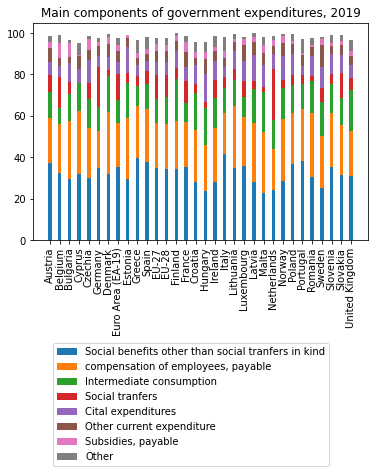

In [15]:
args = requestLib.args_to_dict_fun(table='gov_10a_main', unit = 'PC_GDP', time='2019', sector='S13', na_item='')

social_tranfers = Component('social tranfers','D632PAY', 'Social tranfers')
compensation_emp = Component('compensation of employees','D1PAY', 'compensation of employees, payable')
intermediate_consuption = Component('intermediate consumption','P2', 'Intermediate consumption')
capital_expenditure = Component('capital expenditure', 'P5,NP,P92PAY,P99PAY', 'Cital expenditures')
social_benefits = Component('social benefits','D62PAY', 'Social benefits other than social tranfers in kind')
other = Component('Other current expenditure','D29PAY,D4PAY,D41PAY,D5PAY,D7PAY,D8PAY', 'Other current expenditure')
subsices = Component('subsides','D3PAY', 'Subsidies, payable')
interest = Component('Other', 'D41PAY', 'Other')

instances = [
    social_benefits,
    compensation_emp,
    intermediate_consuption,
    social_tranfers, 
    capital_expenditure,
    other,
    subsices,
    interest
]

lens, instances = return_response(instances, noCountry, client)

min_len_countries = [item.response.lines for item in instances if len(item.response.lines) == min(lens)][0]
diffCountry = [item for item in other.response.lines if item not in min_len_countries]
avoidCountry = noCountry+diffCountry
   
lens, instances = return_response(instances, avoidCountry, client)

client.update_args('na_item=TE')
r = response_fun(client, clean_dict=clean_country, remove_list=avoidCountry, void_item=False, multiplicity='na_item')

expenditure = r.values['Total general government expenditure']

output = prepare_for_plot(instances, expenditure, subtraction=True ,where=('Property income, payable', 2))

plot_x_labels = instances[0].response.x_labels
fig, ax = plt.subplots()
pos = np.arange(len(plot_x_labels))
plt.title("Main components of government expenditures, 2019")
ax.set_xticks(pos)
ax.set_xticklabels(plot_x_labels, rotation = 90)
width = 0.35

b = np.zeros(len(list(output['subsides'].values())))
for i in range(len(instances)):
    a = np.array(list(output[instances[i].name].values()))
    if i == 0:
        ax.bar(pos,a,width, label=instances[i].label)
    else:
        ax.bar(pos,a,width, bottom=b, label=instances[i].label)
    b += a
    
plt.legend(bbox_to_anchor=(0.9, -0.45))
plt.show()

### Restore import settings

In [16]:
# lanch as last commend to restore the previous python import settings
for location in costum_lib_locations:
    try:
        sys.path.remove(location)
    except ValueError:
        print("path already removed")